# Purpose
* The purpose of this script is to assess our options for purchasing an Auto Bagger for Fab
* We consider a few different machines, their cost to purchase, and the savings in labor that they will generate over the coming years
* We use the classic [NPV analysis](https://en.wikipedia.org/wiki/Net_present_value) to measure the feesibility of purchasing any given machine
* Link to some NPV [examples](http://accountingexplained.com/managerial/capital-budgeting/npv)

# Load libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad')

import pandas as pd
import numpy as np
from db2 import *
import xlsxwriter

import datetime as dt
import calendar

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Set contraints and create dict

In [2]:
# can auto bag only parts in CID 704

# our max kit rate is x35 bags/min
# include links to machine specs
# only analyze WITH printing

# key = bagger name
# 0: purchase + installation + software + etc.
# 1: bags per min WITHOUT printing
# 2: bags per min WITH printing

baggers = {'Autobag Pacesetter Model 125 (table top)':[21000.0, 25.0, 14.0], # table top; 125 model
          'Auto Tabletop Bagger T-375 (table top)':[21725.0, 40.0, 30.0], # table top; t-375 "next bag out" model; no foot switch
          'SX (table top)':[22000.0, 35.0, 35.0], # table top
          'Max 12 (stand up machine)':[45000.0, 50.0, 50.0], # stand up machine
          'Rollbag Fill and Seal Model 1275 (table top)':[25000.0, 40.0, 25.0]} # table top; 1275 model

date_start = '2017-01-01'
date_end = '2017-08-31'

In [3]:
baggers

{'Auto Tabletop Bagger T-375 (table top)': [21725.0, 40.0, 30.0],
 'Autobag Pacesetter Model 125 (table top)': [21000.0, 25.0, 14.0],
 'Max 12 (stand up machine)': [45000.0, 50.0, 50.0],
 'Rollbag Fill and Seal Model 1275 (table top)': [25000.0, 40.0, 25.0],
 'SX (table top)': [22000.0, 35.0, 35.0]}

# Get all Fab products contained in bag/CID 704

In [4]:
bag_skus = pd.read_sql(
'''
SELECT
k.part_id,
k.sku_id
FROM products_to_stuff pts
JOIN skus k ON pts.sku_id = k.sku_id AND k.sku_pnp = 1 AND k.sku_outsourced_assembly = 0
WHERE pts.contains_sku_id = 484 
''', db)

all_fab_for_check = pd.read_sql(
'''
SELECT
DISTINCT part_id
FROM skus
WHERE sku_pnp = 1
AND sku_outsourced_assembly = 0
AND sku_status = 'working'
''', db)

In [5]:
print ('count of Fab parts in bag/CID 704: {}'.format(len(bag_skus.index)))
print ('count of all Fab parts regardless of bags: {}'.format(len(all_fab_for_check.index)))

count of Fab parts in bag/CID 704: 286
count of all Fab parts regardless of bags: 313


# Get Fab prep times

In [6]:
main_01 = pd.read_sql(
'''
SELECT

p1.wo_id,
wo.wo_id_string,
wo.sku_id,
k.part_id,
wo.wo_date_created,
wo.wo_date_scheduled,
wo.wo_date_active,
wo.wo_date_completed,
wo.wo_qty,
wo.wo_qty_out,
wo.wo_status,
wo.wo_substatus,
p1.process_id,
p1.process_name,
p1.process_class,
CASE WHEN p1.qty_in < p1.qty_out THEN wo.wo_qty ELSE p1.qty_in END AS qty_in,
p1.qty_out,
CASE WHEN p1.qty_in < p1.qty_out THEN wo.wo_qty ELSE p1.qty_in END - p1.qty_out AS qty_reject,
p1.process_order,

CASE WHEN p1.qty_in < p1.qty_out THEN wo.wo_qty ELSE p1.qty_in END AS spa_qty_in,
p1.qty_out AS spa_qty_out,
CASE WHEN p1.qty_in < p1.qty_out THEN wo.wo_qty ELSE p1.qty_in END - p1.qty_out AS spa_qty_reject,
p1.time_start,
p1.time_end,
p2.spa_time_start,
p2.spa_time_end,
p2.spa_admin

FROM processes p1

JOIN sp_actions p2 ON p1.process_id = p2.process_id
JOIN work_orders wo ON p1.wo_id = wo.wo_id

JOIN
(SELECT
sku_id,
part_id
FROM skus
GROUP BY sku_id) k ON wo.sku_id = k.sku_id

WHERE p1.process_name = 'Fabricate'
GROUP BY p1.wo_id
ORDER BY p1.wo_id, p1.process_order
''', db)

#=====

main_02 = pd.read_sql(
'''
SELECT

p1.wo_id,
wo.wo_id_string,
wo.sku_id,
k.part_id,
wo.wo_date_created,
wo.wo_date_scheduled,
wo.wo_date_active,
wo.wo_date_completed,
wo.wo_qty,
wo.wo_qty_out,
wo.wo_status,
wo.wo_substatus,
p1.process_id,
p1.process_name,
p1.process_class,
CASE WHEN p1.qty_in < p1.qty_out THEN wo.wo_qty ELSE p1.qty_in END AS qty_in,
p1.qty_out,
CASE WHEN p1.qty_in < p1.qty_out THEN wo.wo_qty ELSE p1.qty_in END - p1.qty_out AS qty_reject,
p1.process_order,

p2.spa_qty + p2.spa_qty_reject AS spa_qty_in,
p2.spa_qty AS spa_qty_out,
p2.spa_qty_reject,
p1.time_start,
p1.time_end,
p2.spa_time_start,
p2.spa_time_end,
p2.spa_admin

FROM processes p1

JOIN sp_actions p2 ON p1.process_id = p2.process_id
JOIN work_orders wo ON p1.wo_id = wo.wo_id

JOIN
(SELECT
sku_id,
part_id
FROM skus
GROUP BY sku_id) k ON wo.sku_id = k.sku_id

WHERE p1.process_name != 'Fabricate'
ORDER BY p1.wo_id, p1.process_order
''', db)

main = pd.concat([main_01, main_02])

### Creat year and month column

In [7]:
main['year_and_month'] = pd.to_datetime(main['spa_time_start'].dt.year.map(str) + '-' + main['spa_time_start'].dt.month.map(str))

### Clean and fit data

In [8]:
fab = main.copy()

# get only parts in CID 704
fab = fab[fab['part_id'].isin(bag_skus['part_id'].tolist())]

# start to isolate "prep"
fab = fab[fab['process_class'] == 'processStockSubtract']

# change all to lower case
fab['process_name'] = [x.lower() for x in fab['process_name']]

# get "prep" only
def prep(x):
    if 'prep' in x['process_name']:
        return 'prep'
    else:
        return 'other'

fab['action'] = fab.apply(prep, axis = 1)

# check out what you will drop, just to see
other = fab.copy()
other = other[other['action'] == 'other']

# drop "other"
fab.drop(fab[fab['action'] == 'other'].index, inplace = True)

# get total time
fab['time'] = fab['spa_time_end'] - fab['spa_time_start']

# get "time" percentiles to spot outliers
time_quantiles = fab['time'].quantile(np.arange(0, 1.02, 0.02))
print (time_quantiles.head())
print ('')
print (time_quantiles.tail())

# it seems reasonable to exclude the top and bottom 2%
fab = fab[(fab['time'] > fab['time'].quantile(0.02)) & (fab['time'] <= fab['time'].quantile(0.98))]

# remove where spa_qty_in equals zero
fab = fab[fab['spa_qty_in'] > 0]

0.00          00:00:04
0.02          00:00:16
0.04          00:01:57
0.06   00:04:33.480000
0.08   00:06:53.640000
Name: time, dtype: timedelta64[ns]

0.92   0 days 01:31:39.080000
0.94   0 days 01:43:07.039999
0.96   0 days 02:00:18.800000
0.98   0 days 02:27:25.360000
1.00          2 days 21:36:07
Name: time, dtype: timedelta64[ns]


### Check what we excluded

In [9]:
[x for x in other['process_name'][other['action'] == 'other'].unique()]

['test',
 'qa',
 'test- revision',
 'qa-revision',
 'programming and testing',
 'attach sma',
 'programming and test',
 'attach the sma',
 'testing',
 'attach microphone',
 'test and program',
 'attach microphone / test',
 'program and test',
 'test- revision!!',
 'qa- revision',
 'new - test',
 'programming  testing manual pairing',
 'test- new!!!',
 'test - new',
 'qa - new',
 'test- new!!',
 'qa- new!!',
 'test - new!!',
 'qa - new!!',
 'programming,  testing, manual pairing',
 'test - revision',
 'qa - revision',
 'test - revision!!',
 'test - revised!!',
 'soldering',
 'test- revision!',
 'qa - revision!',
 'test - give directly to qa',
 'test - new!!!',
 'qa - new!!!',
 'test revision',
 'qa revision',
 'solder leds',
 'test- new',
 'testing revision',
 'qa- new',
 'solder',
 'test-revision',
 'test-new',
 'qa-new',
 'soldering - revision',
 'programming,  testing, manual pairing -revision',
 'solder stacking headers',
 'hand solder',
 'test new',
 'qa new',
 'solder - revision',

# Plot prep qty over all time

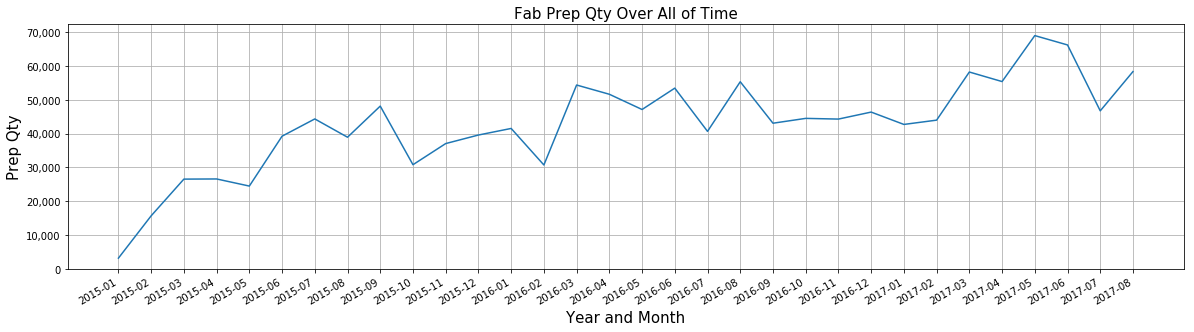

In [70]:
all_time = fab[fab['spa_time_start'] < '2017-09-01'].groupby('year_and_month').agg({'spa_qty_in':'sum'}).rename(columns = {'spa_qty_in':'prep_qty'})

ax = all_time.plot(figsize = (20,5), use_index = False, legend = False)

ax.set_xticks(np.arange(0, len(all_time.index)))
ax.set_xticklabels([str(x)[:7] for x in all_time.index])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.title('Fab Prep Qty Over All of Time', fontsize = 15)
plt.ylabel('Prep Qty', fontsize = 15)
plt.xlabel('Year and Month', fontsize = 15)
plt.grid()
plt.show()

# Forecast prep qty

In [11]:
import warnings
import itertools
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Get training and test sets

In [12]:
test_start_number = int(np.floor(len(all_time.index) * 0.75))
test_start_date = pd.to_datetime(all_time.index[test_start_number])

print (test_start_date)

2017-01-01 00:00:00


### Find best model

In [13]:
# Define the p, d and q parameters
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# specify to ignore warning messages
warnings.filterwarnings('ignore')

dict_ = {}
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(all_time['prep_qty'],
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = True,
                                            enforce_invertibility = True)
            results = mod.fit()
            test = results.get_prediction(start = test_start_date, dynamic = False)
            
            y_forecasted = test.predicted_mean
            y_truth = all_time['prep_qty'][test_start_number:]
            mse = ((y_forecasted - y_truth) ** 2).mean()
            rmse = np.sqrt(mse)
            
            dict_[i] = [param, param_seasonal, results.aic, mse, rmse]
            i = i + 1
        except:
            continue
            
model_search = pd.DataFrame.from_items(dict_.items(),
                       orient = 'index',
                       columns = ['params','seasonal_params','AIC','MSE','RMSE'])

In [14]:
quantile = 0.90

model_search[(model_search['RMSE'] <= model_search['RMSE'].quantile(quantile)) & (model_search['AIC'] <= model_search['AIC'].quantile(quantile))].sort_values('RMSE').head()

,params,seasonal_params,AIC,MSE,RMSE
34,"(1, 0, 1)","(1, 1, 0, 12)",423.246328,5.494708e+07,7412.630049
32,"(1, 0, 1)","(0, 1, 0, 12)",426.039137,5.816561e+07,7626.638122
77,"(2, 0, 2)","(1, 1, 0, 12)",425.301726,5.842421e+07,7643.573021
75,"(2, 0, 1)","(1, 1, 0, 12)",424.059746,5.849759e+07,7648.371461
36,"(1, 0, 2)","(1, 1, 0, 12)",423.430891,6.006930e+07,7750.438427


### Create model

In [15]:
# (1,1,1)(1,1,0)
# (3,0,1)(1,1,0)

In [16]:
model = sm.tsa.statespace.SARIMAX(all_time['prep_qty'],
                                order = (3, 0, 1),
                                seasonal_order = (1, 1, 0, 12),
                                enforce_stationarity = True,
                                enforce_invertibility = True)

results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           prep_qty   No. Observations:                   32
Model:             SARIMAX(3, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -206.679
Date:                            Sat, 13 Jan 2018   AIC                            425.359
Time:                                    10:19:35   BIC                            434.153
Sample:                                01-01-2015   HQIC                           428.274
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6444      0.458      1.407      0.159      -0.253       1.542
ar.L2          0.0446      0.449   

### Plot residuals

In [17]:
results.resid.mean()

7596.42541787492

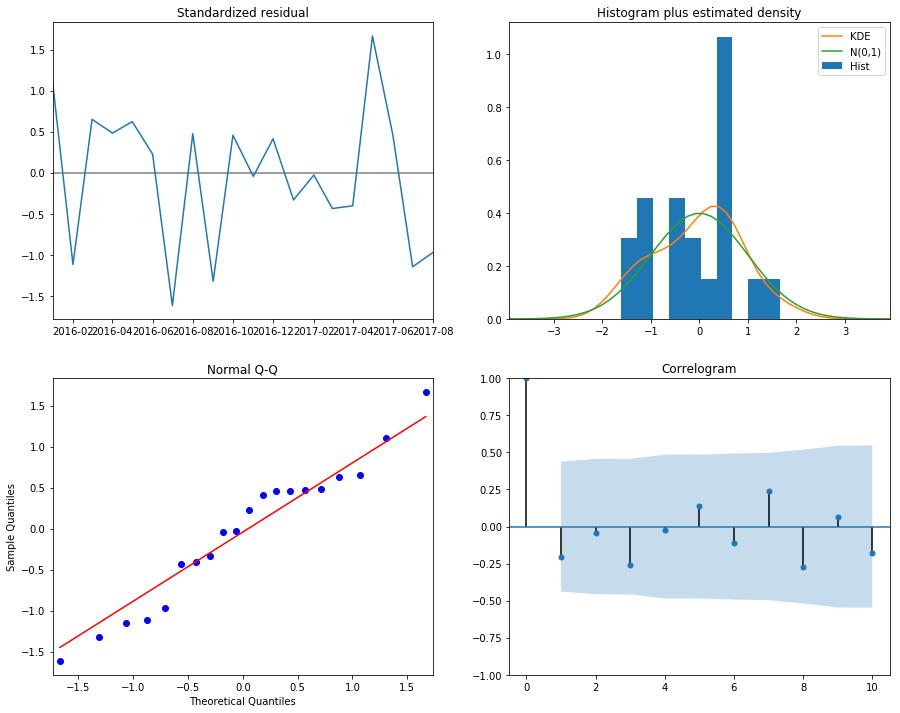

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Validate forecast

In [19]:
test_start_date

Timestamp('2017-01-01 00:00:00')

In [20]:
test = results.get_prediction(start = test_start_date, dynamic = True)
test_ci = test.conf_int()

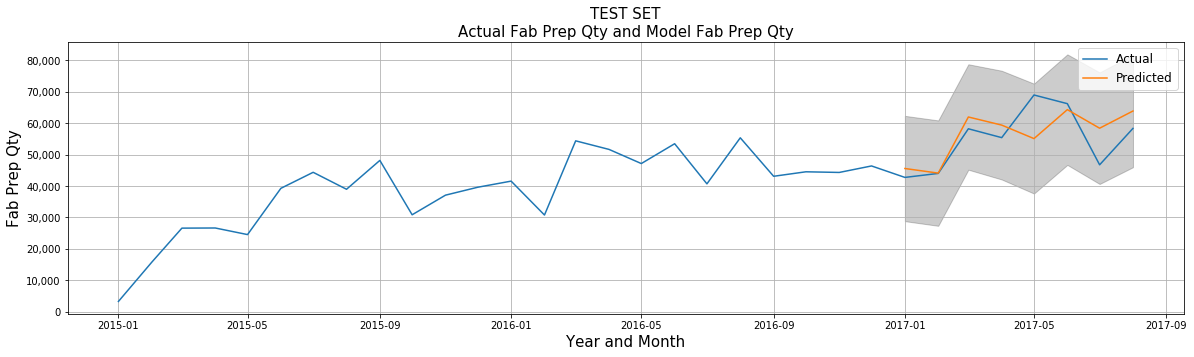

In [21]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1)

plot01, = ax.plot(all_time['prep_qty'], label = 'Actual')
plot02, = ax.plot(test.predicted_mean, label = 'Predicted')

ax.fill_between(test_ci.index,
                test_ci.iloc[:, 0],
                test_ci.iloc[:, 1], color='k', alpha=.2)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.title('TEST SET\nActual Fab Prep Qty and Model Fab Prep Qty', fontsize = 15)
plt.ylabel('Fab Prep Qty', fontsize = 15)
plt.xlabel('Year and Month', fontsize = 15)
plt.legend(handles = [plot01, plot02], loc = 'best', fontsize = 12)
plt.grid()
plt.show()

### Forecast

In [22]:
# a general rule is not to forecast further than the number of data you have
# we have 32 datum points
# we should not forecast past 32 steps which here means 32 months
# from Sep 2017 to Dec is 3
# so we have 29 left which means we can go out as far as 2+ years

print ('total data points: {}'.format(len(all_time)))

total data points: 32


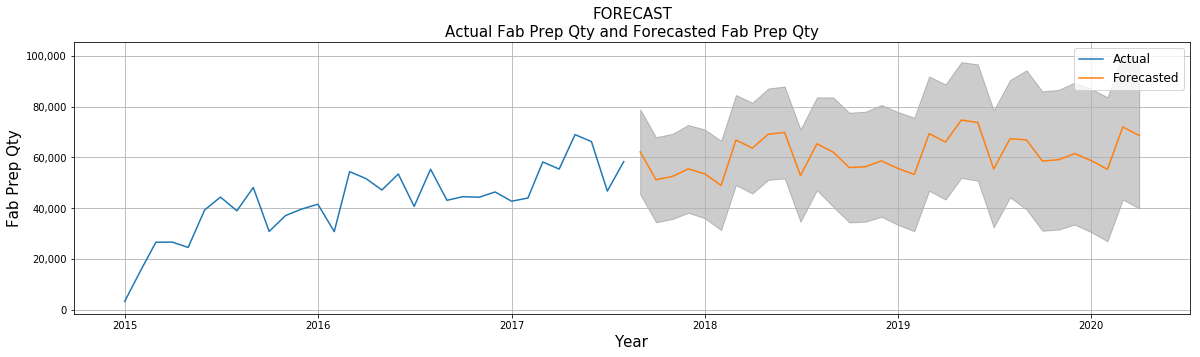

In [23]:
pred = results.get_forecast(steps = len(all_time))
pred_ci = pred.conf_int()

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1)

plot01, = ax.plot(all_time['prep_qty'], label = 'Actual')
plot02, = ax.plot(pred.predicted_mean, label = 'Forecasted')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.title('FORECAST\nActual Fab Prep Qty and Forecasted Fab Prep Qty', fontsize = 15)
plt.ylabel('Fab Prep Qty', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.legend(handles = [plot01, plot02], loc = 'best', fontsize = 12)
plt.grid()
plt.show()

### Final forecast

In [24]:
forecast_df = pd.DataFrame({'prep_qty':pred.predicted_mean})
forecast_df.index.rename('year_and_month', inplace = True)
forecast_df.reset_index(inplace = True)

forecast_df['prep_qty'] = [int(np.round(x)) for x in forecast_df['prep_qty']]

# cut off the end which extends past 2 calendar years
forecast_df = forecast_df[forecast_df['year_and_month'] <= '2019-12-01']

In [25]:
forecast_df

,year_and_month,prep_qty
0,2017-09-01,62183
1,2017-10-01,51194
2,2017-11-01,52480
3,2017-12-01,55470
4,2018-01-01,53501
5,2018-02-01,48946
6,2018-03-01,66835
7,2018-04-01,63652
8,2018-05-01,69128
9,2018-06-01,69823


# Get recent Fab data and structure it
* Recall that the Fab dataframe has already been cleaned and semi-structured
* It contains only rows where prepping occurred

In [26]:
print (date_start, date_end)

2017-01-01 2017-08-31


In [27]:
fab_by_date = fab.copy()

# get data starting in Jan 2017 and ending in Aug 2017
fab_by_date = fab_by_date[(fab_by_date['spa_time_start'] >= pd.to_datetime(date_start)) & (fab_by_date['spa_time_start'] <= pd.to_datetime(date_end))]

# groupby year and month and sun prep qty and the time it takes to prep
fab_by_date = fab_by_date.groupby('year_and_month', as_index = False).agg({'spa_qty_in':'sum','time':'sum'})

# rename columns
fab_by_date.rename(columns = {'spa_qty_in':'prep_qty'}, inplace = True)

# change time to minutes
fab_by_date['time'] = fab_by_date['time']/pd.Timedelta('1 minute')

fab_by_date.head()

,year_and_month,prep_qty,time
0,2017-01-01,42716,13213.716667
1,2017-02-01,43982,14519.516667
2,2017-03-01,58202,18123.416667
3,2017-04-01,55382,18036.166667
4,2017-05-01,68964,21500.166667


### Get recent avg part per min
* Recall that this is the parts per min from data starting Jan 2017 and ending Aug 2017

In [28]:
mean_parts_per_min = (fab_by_date['prep_qty']/fab_by_date['time']).mean()
mean_parts_per_min

3.16064149752607

# Apply avg parts per min to forecast
* To get the total time to prep the forecasted qty, we do qty/(qty/min) where qty cancels and you're left with minutes
* Then convert those minutes to time

In [29]:
forecast_df['time'] = (forecast_df['prep_qty']/mean_parts_per_min)# * pd.Timedelta('1 minute')

# Concat actual and forecasts

In [30]:
print ('forecast begins on {}'.format(str(forecast_df['year_and_month'].iloc[0])[:10]))

forecast begins on 2017-09-01


In [31]:
# concat recent actual and forecasted
prep_main = pd.concat([fab_by_date, forecast_df], ignore_index = True)

# create year column
prep_main['year'] = prep_main['year_and_month'].dt.year

# isolate just these columns
prep_main = prep_main[['year_and_month','year','prep_qty','time']]

### Plot actual and forecast together
* Recall that the forecast begins on 2017-09-01

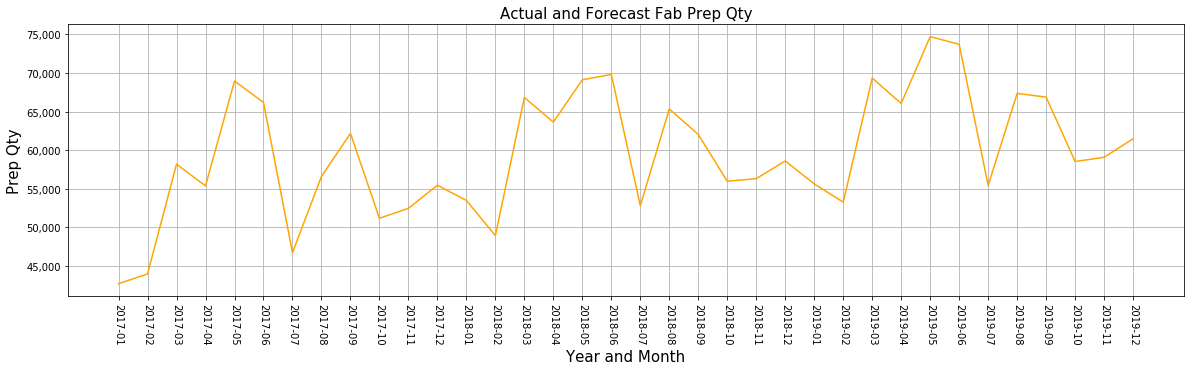

In [32]:
ax = prep_main['prep_qty'].plot(figsize = (20,5), color = 'orange')

ax.set_xticks(np.arange(0, len(prep_main.index)))
ax.set_xticklabels([str(x)[:7] for x in prep_main['year_and_month']], rotation = 270)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.title('Actual and Forecast Fab Prep Qty', fontsize = 15)
plt.ylabel('Prep Qty', fontsize = 15)
plt.xlabel('Year and Month', fontsize = 15)
plt.grid()
plt.show()

# Apply baggers

In [33]:
# can auto bag only parts in CID 704

# our max kit rate is x35 bags/min
# include links to machine specs
# only analyze WITH printing

# key = bagger name
# 0: purchase + installation + software + etc.
# 1: bags per min WITHOUT printing
# 2: bags per min WITH printing

baggers

{'Auto Tabletop Bagger T-375 (table top)': [21725.0, 40.0, 30.0],
 'Autobag Pacesetter Model 125 (table top)': [21000.0, 25.0, 14.0],
 'Max 12 (stand up machine)': [45000.0, 50.0, 50.0],
 'Rollbag Fill and Seal Model 1275 (table top)': [25000.0, 40.0, 25.0],
 'SX (table top)': [22000.0, 35.0, 35.0]}

In [34]:
prep_in_time = prep_main.copy()

# this gets the total time in minutes per bagger to prep the given total qty
for key, value in baggers.items():
    # recall that we only want the time to bag WITH printing
    df = pd.DataFrame({key:prep_in_time['prep_qty']/value[2]})
    prep_in_time = prep_in_time.merge(df, left_index = True, right_index = True, copy = False)

# Get labor costs
* assume the avg prepper makes \$18/hour = $0.30/minute

In [35]:
labor_per_minute = 0.30

In [36]:
# recall that prep_in_time is the total prep time in minutes per machine to prep the given qty
prep_in_cost = prep_in_time.copy()

# rename time to cost 
prep_in_cost.rename(columns = {'time':'cost'}, inplace = True)

# apply labor_per_minute to the time (in minutes) columns only
prep_in_cost.iloc[:, 3:] = prep_in_cost.iloc[:, 3:] * labor_per_minute

* Assume we purchase a machine on Jan 01, 2018

In [37]:
# remember that the data frame below is how much labor currently costs and what labor would cost under each machine

prep_in_cost = prep_in_cost[prep_in_cost['year_and_month'] >= '2018-01-01']

# sum totals per year
prep_in_cost_by_year = prep_in_cost.groupby('year').sum()
prep_in_cost_by_year

,prep_qty,cost,Autobag Pacesetter Model 125 (table top),Auto Tabletop Bagger T-375 (table top),SX (table top),Max 12 (stand up machine),Rollbag Fill and Seal Model 1275 (table top)
year,,,,,,,
2018,723021,68627.302454,15493.307143,7230.21,6197.322857,4338.126,8676.252
2019,761591,72288.268119,16319.807143,7615.91,6527.922857,4569.546,9139.092


### From current cost subtract the cost of each machine
* This will tell us how much we will save per year using some machine

In [38]:
prep_in_savings_by_year = prep_in_cost_by_year.copy()

# because of how this pd.subtract thing works I had to subtract all machines cost from the current cost
# and multiple by minus 1
prep_in_savings_by_year.iloc[:,2:] = -1 * prep_in_savings_by_year.iloc[:,2:].subtract(prep_in_savings_by_year['cost'].values, axis = 'index')
prep_in_savings_by_year

,prep_qty,cost,Autobag Pacesetter Model 125 (table top),Auto Tabletop Bagger T-375 (table top),SX (table top),Max 12 (stand up machine),Rollbag Fill and Seal Model 1275 (table top)
year,,,,,,,
2018,723021,68627.302454,53133.995311,61397.092454,62429.979597,64289.176454,59951.050454
2019,761591,72288.268119,55968.460976,64672.358119,65760.345261,67718.722119,63149.176119


# Apply NPV

In [39]:
repair = 500.0

# the anticipated lifespan of each machine is really 7 years
# but because we don't have enough data we cannot forecast out as far as 7 years
# so we forecastes out as far as 2 years
# therefore we'll pretend that the lifespan is actually 2 years so our data matches up
lifespan = 2
salvage_value = 0.0
rate = 0.07

baggers

{'Auto Tabletop Bagger T-375 (table top)': [21725.0, 40.0, 30.0],
 'Autobag Pacesetter Model 125 (table top)': [21000.0, 25.0, 14.0],
 'Max 12 (stand up machine)': [45000.0, 50.0, 50.0],
 'Rollbag Fill and Seal Model 1275 (table top)': [25000.0, 40.0, 25.0],
 'SX (table top)': [22000.0, 35.0, 35.0]}

In [40]:
pv_df = pd.DataFrame({'present_value':np.nan}, index = baggers.keys())

for key, value in baggers.items():
    
    # isolate each machine column
    df = prep_in_savings_by_year[key]
    
    # create a list to hold out present values
    pv_list = []
    
    # discount the cashflows (savings in labor) back along the lifespan
    for t in range(lifespan):
        if t == 0: # no repairs in the first year
            pv = df.iloc[t]/(1 + rate)**t
            pv_list.append(pv)
        else: # repairs every other year
            pv = (df.iloc[t] - repair)/(1 + rate)**t
            pv_list.append(pv)
    # factor in the cash outflow of buying the machine and sum the present values
    pv = (baggers[key][0] * -1) + np.sum(pv_list)
    
    # set the values for the data frame
    pv_df.set_value(key, 'present_value', pv)

In [41]:
pv_df.sort_values('present_value', ascending = False, inplace = True)

pv_df_format = pv_df.copy()
pv_df_format['present_value'] = ['${:,.0f}'.format(x) for x in pv_df_format['present_value']]
pv_df_format.rename(columns = {'present_value':'Present Value'}, inplace = True)
pv_df_format

,Present Value
SX (table top),"$101,421"
Auto Tabletop Bagger T-375 (table top),"$99,646"
Rollbag Fill and Seal Model 1275 (table top),"$93,502"
Autobag Pacesetter Model 125 (table top),"$83,974"
Max 12 (stand up machine),"$82,110"


# Join other machine attributes to judge which one to buy

### annual mean prep times

In [42]:
# recall that prep_in_time data frame is the time spent prepping in minutes
prep_in_time_by_year = prep_in_time.copy()

# change the columns name
prep_in_time_by_year = prep_in_time_by_year.rename(columns = {'time':'Currently'})

# drop qty since we don't care about that right now
prep_in_time_by_year.drop(['prep_qty'],1,inplace = True)

# get the avg prep time per year
prep_in_time_by_year = prep_in_time_by_year.groupby('year').sum().mean()

In [43]:
df1 = pd.DataFrame({'annual_mean_prep_times':prep_in_time_by_year*pd.Timedelta('1 minute')}).sort_values('annual_mean_prep_times')

In [44]:
df1_format = df1.copy()
df1_format['annual_mean_prep_times'] = [str(x)[:16] for x in df1_format['annual_mean_prep_times']]
df1_format.rename(columns = {'annual_mean_prep_times':'Annual Mean Prep Times'}, inplace = True)
df1_format

,Annual Mean Prep Times
Max 12 (stand up machine),9 days 22:18:10.
SX (table top),14 days 04:25:57
Auto Tabletop Bagger T-375 (table top),16 days 13:10:17
Rollbag Fill and Seal Model 1275 (table top),19 days 20:36:20
Autobag Pacesetter Model 125 (table top),35 days 11:04:54
Currently,157 days 01:21:2


### annual mean labor costs

In [45]:
# recall that we already have this data frame made
# we just need to get the average

df2 = pd.DataFrame({'annual_mean_labor_costs':prep_in_cost_by_year.drop('prep_qty',1).rename(columns = {'cost':'Currently'}).mean()}).sort_values('annual_mean_labor_costs')

In [46]:
df2_format = df2.copy()
df2_format['annual_mean_labor_costs'] = ['${:,.0f}'.format(x) for x in df2_format['annual_mean_labor_costs']]
df2_format.rename(columns = {'annual_mean_labor_costs':'Annual Mean Labor Costs'}, inplace = True)
df2_format

,Annual Mean Labor Costs
Max 12 (stand up machine),"$4,454"
SX (table top),"$6,363"
Auto Tabletop Bagger T-375 (table top),"$7,423"
Rollbag Fill and Seal Model 1275 (table top),"$8,908"
Autobag Pacesetter Model 125 (table top),"$15,907"
Currently,"$70,458"


### annual mean labor savings

In [47]:
# recall that we already have this data frame made too

df3 = pd.DataFrame({'annual_mean_labor_savings':prep_in_savings_by_year.iloc[:, 2:].mean()}).sort_values('annual_mean_labor_savings', ascending = False)

In [48]:
df3_format = df3.copy()
df3_format['annual_mean_labor_savings'] = ['${:,.0f}'.format(x) for x in df3_format['annual_mean_labor_savings']]
df3_format.rename(columns = {'annual_mean_labor_savings':'Annual Mean Labor Savings'}, inplace = True)
df3_format

,Annual Mean Labor Savings
Max 12 (stand up machine),"$66,004"
SX (table top),"$64,095"
Auto Tabletop Bagger T-375 (table top),"$63,035"
Rollbag Fill and Seal Model 1275 (table top),"$61,550"
Autobag Pacesetter Model 125 (table top),"$54,551"


# Put all of the outputs together

In [49]:
output = pd.merge(df1, df2, how = 'left', left_index = True, right_index = True)
output = pd.merge(output, df3, how = 'left', left_index = True, right_index = True, copy = False)
output = pd.merge(output, pv_df_format, how = 'left', left_index = True, right_index = True, copy = False)

In [50]:
output_format = output.copy()
output_format.rename(columns = {'annual_mean_prep_times':'Mean Prep Time per Year',
                                'annual_mean_labor_costs':'Mean Labor Cost per Year',
                                'annual_mean_labor_savings':'Mean Savings per Year'}, inplace = True)

output_format['Mean Prep Time per Year'] = [str(x)[:16].replace('.','') for x in output_format['Mean Prep Time per Year']]
output_format['Mean Labor Cost per Year'] = ['${:,.0f}'.format(x) for x in output_format['Mean Labor Cost per Year']]
output_format['Mean Savings per Year'] = ['${:,.0f}'.format(x) for x in output_format['Mean Savings per Year']]

output_format.replace('$nan','', inplace = True)
output_format.fillna('', inplace = True)

output_format['Initial Cost'] = ['$45,000','$22,000','$21,725','$25,000','$21,000','']
output_format['Bags per Minute with Printing'] = [50,35,30,25,14,'']
output_format

,Mean Prep Time per Year,Mean Labor Cost per Year,Mean Savings per Year,Present Value,Initial Cost,Bags per Minute with Printing
Max 12 (stand up machine),9 days 22:18:10,"$4,454","$66,004","$82,110","$45,000",50
SX (table top),14 days 04:25:57,"$6,363","$64,095","$101,421","$22,000",35
Auto Tabletop Bagger T-375 (table top),16 days 13:10:17,"$7,423","$63,035","$99,646","$21,725",30
Rollbag Fill and Seal Model 1275 (table top),19 days 20:36:20,"$8,908","$61,550","$93,502","$25,000",25
Autobag Pacesetter Model 125 (table top),35 days 11:04:54,"$15,907","$54,551","$83,974","$21,000",14
Currently,157 days 01:21:2,"$70,458",,,,


# Check Fab proportions

In [51]:
check = main.copy()
check['year'] = check['spa_time_start'].dt.year
check['process_name'] = [x.lower() for x in check['process_name']]
check = check[~check['process_name'].str.contains('kitt')]

In [52]:
def check_time(x):
    if 'fab' in x['process_name']:
        return x['time_end'] - x['time_start']
    else:
        return x['spa_time_end'] - x['spa_time_start']
check['time'] = check.apply(check_time, axis = 1)

In [53]:
def check_action(x):
    if 'fabricate' in x['process_name']:
        return 'fab'
    elif 'test' in x['process_name']:
        return 'test'
    elif 'prep' in x['process_name']:
        return 'prep'
    elif 'qa' in x['process_name']:
        return 'qa'
    elif 'attach' in x['process_name'] or 'solder' in x['process_name']:
        return 'attach/solder'
    else:
        return 'laser cut/clean and tape/programming'
check['action'] = check.apply(check_action, axis = 1)

In [54]:
check_by_year = check.groupby(['year','action']).agg({'time':'sum','spa_qty_in':'sum'}).rename(columns = {'spa_qty_in':'qty'})
check_by_year['qty per min'] = check_by_year['qty']/(check_by_year['time']/pd.Timedelta('1 minute'))
check_by_year['qty per min'] = [int(np.round(x)) for x in check_by_year['qty per min']]

In [55]:
check_by_year

time     qty  \
year action                                                           
2015 attach/solder                         14 days 19:46:30   25216   
     fab                                  218 days 23:49:48  746605   
     laser cut/clean and tape/programming   0 days 17:11:16    2837   
     prep                                 180 days 18:44:31  653927   
     qa                                    13 days 01:45:04  590616   
     test                                 229 days 09:49:33  694723   
2016 attach/solder                         39 days 04:41:19   63603   
     fab                                  320 days 02:21:48  551496   
     laser cut/clean and tape/programming   1 days 09:46:15    2949   
     prep                                 230 days 17:39:55  841102   
     qa                                    13 days 05:21:18  846380   
     test                                 277 days 13:35:23  887598   
2017 attach/solder                         31 days 10:41:57   60502   
     fab                                  213 days 19:24:55  485903   
     laser cut/clean and tape/programming   2 days 07:43:09   22695   
     prep                                 258 days 14:14:58  967783   
     qa                                    33 days 00:32:12  968973   
     test                                 328 days 01:18:04  999445   
2018 attach/solder                          0 days 21:39:31    1641   
     fab                                    1 days 09:21:58   26941   
     laser cut/clean and tape/programming   0 days 00:58:26     602   
     prep                                   9 days 03:04:22   40402   
     qa                                     0 days 17:16:39   39984   
     test                                  10 days 20:17:41   41914   

                                           qty per min  
year action                                             
2015 attach/solder                                   1  
     fab                                             2  
     laser cut/clean and tape/programming            3  
     prep                                            3  
     qa                                             31  
     test                                            2  
2016 attach/solder                                   1  
     fab                                             1  
     laser cut/clean and tape/programming            1  
     prep                                            3  
     qa                                             44  
     test                                            2  
2017 attach/solder                                   1  
     fab                                             2  
     laser cut/clean and tape/programming            7  
     prep                                            3  
     qa                                             20  
     test                                            2  
2018 attach/solder                                   1  
     fab                                            13  
     laser cut/clean and tape/programming           10  
     prep                                            3  
     qa                                             39  
     test                                            3

In [56]:
check_by_year[check_by_year.index.get_level_values(level = 1) == 'prep']

,,time,qty,qty per min
year,action,,,
2015,prep,180 days 18:44:31,653927,3
2016,prep,230 days 17:39:55,841102,3
2017,prep,258 days 14:14:58,967783,3
2018,prep,9 days 03:04:22,40402,3


In [57]:
check_by_year[check_by_year.index.get_level_values(level = 1) == 'prep']['qty per min'].mean()

3.0

# Recap after auto bagger purchased and set up

In [61]:
# recall that the auto-bagger can only do parts contained in bag CID 704
bag_skus.head()

,part_id,sku_id
0,163,8258
1,757,8366
2,815,8381
3,935,8409
4,987,8420


In [71]:
fab.head()

,wo_id,wo_id_string,sku_id,part_id,wo_date_created,wo_date_scheduled,wo_date_active,wo_date_completed,wo_qty,wo_qty_out,wo_status,wo_substatus,process_id,process_name,process_class,qty_in,qty_out,qty_reject,process_order,spa_qty_in,spa_qty_out,spa_qty_reject,time_start,time_end,spa_time_start,spa_time_end,spa_admin,year_and_month,action,time
64,41,1362-C8492-001-41,8492,1362,2014-12-02,2015-02-20,2015-02-26 11:54:26,2015-02-27 14:25:31,299,299,completed,completed,1114,prep,processStockSubtract,299,299,0,4,99,99,0,2015-02-27 08:30:37,2015-02-27 14:25:04,2015-02-27 12:57:44,2015-02-27 13:18:49,carlo,2015-02-01,prep,00:21:05
66,41,1362-C8492-001-41,8492,1362,2014-12-02,2015-02-20,2015-02-26 11:54:26,2015-02-27 14:25:31,299,299,completed,completed,1114,prep,processStockSubtract,299,299,0,4,100,100,0,2015-02-27 08:30:37,2015-02-27 14:25:04,2015-02-27 12:03:07,2015-02-27 12:37:32,carlo,2015-02-01,prep,00:34:25
81,44,269-C8285-001-44,8285,269,2014-12-02,2015-01-15,2015-01-15 11:34:32,2015-02-20 15:02:44,1325,1325,completed,completed,539,prep,processStockSubtract,1325,1325,0,4,200,200,0,2015-01-16 15:51:11,2015-02-20 15:02:17,2015-01-27 12:06:46,2015-01-27 12:41:02,will,2015-01-01,prep,00:34:16
82,44,269-C8285-001-44,8285,269,2014-12-02,2015-01-15,2015-01-15 11:34:32,2015-02-20 15:02:44,1325,1325,completed,completed,539,prep,processStockSubtract,1325,1325,0,4,100,100,0,2015-01-16 15:51:11,2015-02-20 15:02:17,2015-01-22 17:49:25,2015-01-22 18:12:24,alicia,2015-01-01,prep,00:22:59
83,44,269-C8285-001-44,8285,269,2014-12-02,2015-01-15,2015-01-15 11:34:32,2015-02-20 15:02:44,1325,1325,completed,completed,539,prep,processStockSubtract,1325,1325,0,4,200,200,0,2015-01-16 15:51:11,2015-02-20 15:02:17,2015-01-20 14:41:33,2015-01-20 15:42:21,damon,2015-01-01,prep,01:00:48
